## Filter-based System Level tube-MPC (SLTMPC)

This notebook demonstrates the use of the filter-based SLTMPC method proposed in [1] on an uncertain double integrator system. The method is designed to handle uncertainties in the system dynamics and additive disturbances, providing a general robust control solution. In the notebook, the method is compared to the SLS-MPC method proposed in [2].

**Disclaimer**: While the notebook demonstrates the same aspects as in the paper, the empirical results differ from those in the paper. The intention of this notebook is to be educational and it should be relatively fast to run. To obtain the same results as in the paper, many more trajectories would need to be simulated and region of attraction (RoA) and coverage sets would need to be computed with a finer grid size. Where applicable, the notebook provides remarks on how to obtain the same (or more similar) results as in the paper.

The cells in these notebook should at most take a few minutes to run.

[1] J. Sieber, A. Didier, and M. N. Zeiligner, "Computationally efficient system level tube-MPC for uncertain systems", Automatica, 2025.

[2] S. Chen, V. M. Preciado, M. Morari, and N. Matni, "Robust Model Predictive Control with Polytopic Model Uncertainty through System Level Synthesis", Automatica, 2024.

This notebook requires the `ampyc` package, which can be installed via `pip install ampcy`. The `ampyc` package is a general-purpose simulation and control library for predictive control methods, more information can be found [here](https://github.com/IntelligentControlSystems/ampyc).

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

from ampyc.controllers import available_solvers

First, we check if MOSEK is available on the system, since it is the default solver used in this notebook. If it is not available, other solvers can be used, but the results may differ. E.g. replace `solver='MOSEK'` with `solver='ECOS'` (or another solver) in the cells below.

In [2]:
# print all available solvers
available_solvers()

CVXPY available solvers:
    [   'CLARABEL',
    'CVXOPT',
    'ECOS',
    'ECOS_BB',
    'GLPK',
    'GLPK_MI',
    'MOSEK',
    'OSQP',
    'SCIPY',
    'SCS']
further information on solvers at:
    https://www.cvxpy.org/tutorial/solvers/index.html

CasADi available solvers:
    [   'ampl', 'blocksqp', 'bonmin', 'fatrop', 'ipopt', 'qrsqp', 'scpgen',
    'sqpmethod', 'feasiblesqpmethod']
further information on solvers at:
    https://web.casadi.org/api/internal/d4/d89/group__nlpsol.html



In [3]:
# import convenience methods from ampyc
from ampyc.utils import Polytope, compute_mrpi, compute_RoA

# import SLTMPC and SLS-MPC methods
from sltmpc.systems import UncertainDoubleIntegrator
from sltmpc.parameters import FilterSLTMPCParams
from sltmpc.controllers import Filter_SLTMPC, SLS_MPC
from sltmpc.utils import compute_mrci

Then, we load the [default parameters](sltmpc/parameters/params_filter_sltmpc.py) and initialize the uncertain double integrator system. Next, we compute the maximum robust control invariant set (RCI) for the system, which is used as the terminal set for SLS-MPC and one version of filter-based SLTMPC.

In [4]:
params = FilterSLTMPCParams()
sys = UncertainDoubleIntegrator(params.sys)

Successfully initialized experiment 'Filter-based SLTMPC'.


MRCI computation converged after 5 iterations.


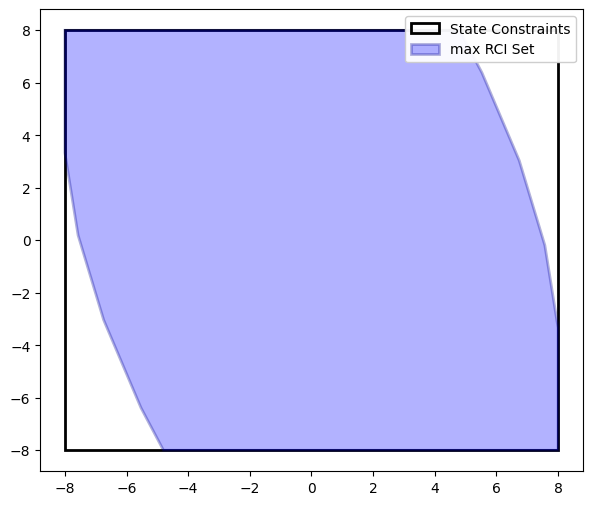

In [5]:
# compute the maximum RCI set
X_f = compute_mrci(sys, max_iter=100)

# plot the maximum RCI set in the state constraints
_, ax = plt.subplots(1, 1, figsize=(7, 6))
sys.X.plot(ax, fill=False, alpha=1, linewidth=2, color='black', label='State Constraints')
X_f.plot(ax, fill=True, alpha=0.3, color='blue', edgecolor="darkblue", linewidth=2, label='max RCI Set')

ax.set_xlim(sys.X.xlim)
ax.set_ylim(sys.X.ylim)

plt.legend(loc='upper right', framealpha=0.95)
plt.show()

### Comparison of filter-based SLTMPC and SLS-MPC

First, we demonstrate that filter-based SLTMPC (optimization problem (23) in [1]) contains the SLS-MPC method [2] as a special case. For this, we design the auxiliary disturbance set $\tilde{\mathcal{W}}$ as a hypercube with edge length $1$ and structure the diagonal of the filter $\Sigma$ as diagonal matrices (see Remark 2 in [1]). For both methods, we use the maximum RCI set as the terminal set $\mathcal{X}_f$.

Additionally, we add regularization terms to both methods to ensure that the solver produces comparable results.

In [6]:
# define auxiliary disturbance and initialize filter-based SLTMPC
W_tilde = Polytope(A=sys.W.A, b=np.ones(sys.W.b.shape))
slt = Filter_SLTMPC(sys, params.ctrl, solver='MOSEK', X_f=X_f, P_f=params.ctrl.Q, K_f=np.zeros((1,)),
                    W_tilde=W_tilde, structure="diagonal", scale_terminal_set=False,
                    regularize=lambda x: cp.norm(x[0], 'fro') + cp.norm(x[1], 'fro'))

# initialize SLS-MPC
chen = SLS_MPC(sys, params.ctrl, solver='MOSEK', X_f=X_f, P_f=params.ctrl.Q,
               regularize=lambda x: cp.norm(x[0], 'fro') + cp.norm(x[1], 'fro'))

In [7]:
# obtain initial state from parameters
x_0 = params.sim.x_0

# solve filter-based SLTMPC
v, z, out, error_msg = slt.solve(x_0, verbose=False)
# check if an error occurred during the optimization
if error_msg != None:
    raise Exception(error_msg)

# solve SLS-MPC
v_chen, z_chen, out_chen, error_msg = chen.solve(x_0, verbose=False)
# check if an error occurred during the optimization
if error_msg != None:
    raise Exception(error_msg)

We compare the solution of filter-based SLTMPC and SLS-MPC and ensure they are similar. The results may differ slightly due to the inherent numerical differences in the optimization problem, but they should be within 1e-4 in the maximum norm.

In [8]:
z_diff = np.linalg.norm(z - z_chen, np.inf)
Phi_e_diff = np.linalg.norm(out["Phi_e"] - out_chen["Phi_x"], np.inf)
print(f"Difference in nominal state trajectory: {z_diff:.2e}")
print(f"Difference in state system response: {Phi_e_diff:.2e}")

Difference in nominal state trajectory: 3.91e-05
Difference in state system response: 2.63e-04


Next, we compute the region of attraction (RoA), i.e., the set of initial states for which a MPC method are feasible, for both methods. The RoA is computed by gridding the state constraints and checking for feasibility of the optimization problem for each grid point.

**Remark:** Here, the choice of solver and the grid size for the RoA computation can have a significant impact on the results. To obtain more accurate results, a finer grid size can be used, e.g., `grid_size=50` (or even higher) instead of `grid_size=20`. However, this will also significantly increase the computation time.

Computing RoA for filter-based SLTMPC...


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:46<00:00,  2.35s/it]


Computing RoA for SLS-MPC...


100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


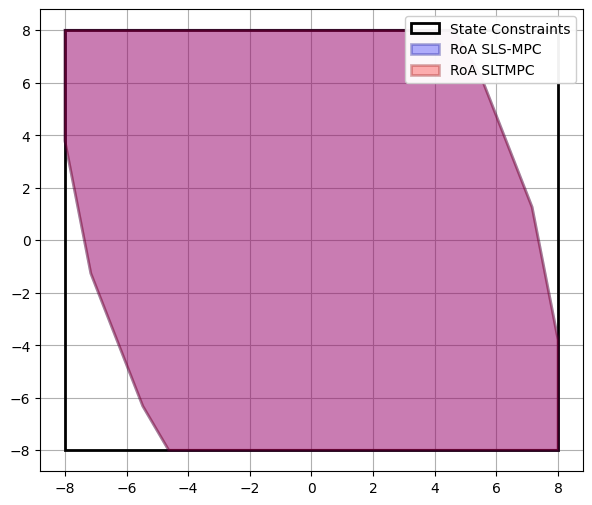

In [9]:
# compute the RoAs for both methods
print("Computing RoA for filter-based SLTMPC...")
RoA = compute_RoA(slt, sys, grid_size=20, solver='MOSEK')
print("Computing RoA for SLS-MPC...")
RoA_chen = compute_RoA(chen, sys, grid_size=20, solver='MOSEK')

# plot the RoAs
_, ax = plt.subplots(1, 1, figsize=(7, 6))

sys.X.plot(ax=ax, fill=False, color="black", linewidth=2, alpha=1., label='State Constraints')
RoA_chen.plot(ax=ax, color="blue", edgecolor="darkblue", linewidth=2, alpha=0.3, label='RoA SLS-MPC')
RoA.plot(ax=ax, color="red", edgecolor="darkred", linewidth=2, alpha=0.3, label='RoA SLTMPC')

ax.set_xlim(sys.X.xlim)
ax.set_ylim(sys.X.ylim)

plt.legend(loc="upper right", framealpha=0.95)
plt.grid()
plt.show()

The two RoAs are indistinguishable, which is expected since the two methods are equivalent in this case. To also check the equivalence programmatically, we can directly check equivalence.

**Remark:** During the RoA computation, you may notice that SLS-MPC is slightly faster than filter-based SLTMPC. This is expected, since the filter-based SLTMPC method is more general and thus employs dual variables to solve the optimization problem, which leads to higher computational costs. However, the difference in computation time is not significant and can be neglected for most applications.

In [10]:
RoA == RoA_chen

True

With this, we have demonstrated that filter-based SLTMPC contains SLS-MPC as a special case.

Often, we are interested in comparing the size of the RoA with respect to the maximum RCI set (which is the larges RoA for any MPC method). For this, we compute the RoA coverage of the maximum RCI set, i.e., the ratio of the RoA volume to the maximum RCI set volume.

In [11]:
def compute_coverage(RoA, X_f, X, grid_size=200):
    """
    Compute the coverage of the RoA with respect to the robust pre-set X_f and the state set X.
    """
    grid_size = grid_size**2
    grid = X.grid(grid_size)
    grid = grid.reshape(-1,2)

    idx = X_f.contains(grid.T)
    idx_roa = RoA.contains(grid.T)
    
    return idx_roa.sum() / idx.sum()

Since both methods are equivalent, the coverage is the same for both. Note that for both methods, the coverage is extremely high, which indicates that the methods are nonconservative.

In [12]:
print(f"Filter-based SLTMPC coverage: {compute_coverage(RoA, X_f, sys.X, grid_size=200):.2%}")
print(f"SLS-MPC coverage: {compute_coverage(RoA_chen, X_f, sys.X, grid_size=200):.2%}")

Filter-based SLTMPC coverage: 98.76%
SLS-MPC coverage: 98.76%


Above, we demonstrated the case where filter-based SLTMPC and SLS-MPC are equivalent. In the following, we demonstrate the case where filter-based SLTMPC is more general than SLS-MPC, i.e., where filter-based SLTMPC can handle uncertainties better than SLS-MPC.

Since SLS-MPC is designed for additive disturbances lying in a hyperrectangle, we modify the default disturbance set $\mathcal{W}$ to a more general polytope.

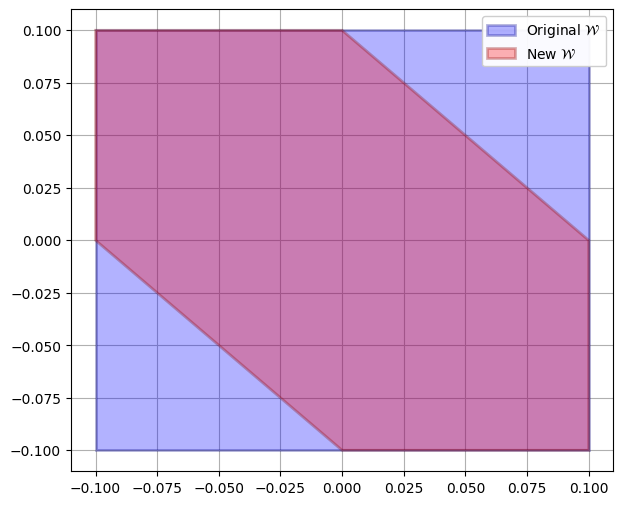

In [13]:
# define new disturbance set
sig_w = params.sys.sig_w
W = Polytope(np.array([[0, -1], [1, 0], [1, 1], [0, 1], [-1, 0], [-1, -1]]),
             np.array([sig_w, sig_w, sig_w, sig_w, sig_w, sig_w]))

# plot the original and the new disturbance sets
_, ax = plt.subplots(1, 1, figsize=(7, 6))
sys.W.plot(ax, fill=True, alpha=0.3, color='blue', edgecolor="darkblue", linewidth=2, label='Original $\mathcal{W}$')
W.plot(ax, fill=True, alpha=0.3, color='red', edgecolor="darkred", linewidth=2, label='New $\mathcal{W}$')

ax.set_xlim(sys.W.xlim)
ax.set_ylim(sys.W.ylim)

plt.legend(loc='upper right', framealpha=0.95)
plt.grid()
plt.show()

In [14]:
# increase size of new disturbance set to better show the differences below
sig_w = 0.5
W = Polytope(np.array([[0, -1], [1, 0], [1, 1], [0, 1], [-1, 0], [-1, -1]]),
             np.array([sig_w, sig_w, sig_w, sig_w, sig_w, sig_w]))

# set the new disturbance set in the system
sys.W = W
# set the new disturbance set as the auxiliary disturbance set for filter-based SLTMPC
W_tilde = W

To show how the overapproximation of the combined model and additive uncertainties works, we plot the evolution of the uncertain dynamics plus the disturbance set $\mathcal{W}$ for one example time step. We do this for filter-based SLTMPC and the new disturbance set we defined above. Here, we set the auxiliary disturbance set $\tilde{\mathcal{W}}$ to the disturbance set $\mathcal{W}$ and use a scalar to scale $\tilde{\mathcal{W}}$, i.e., the diagonal of the filter $\Sigma$ is structured as scalars instead of diagonal matrices as before (see Remark 2 in [1]).

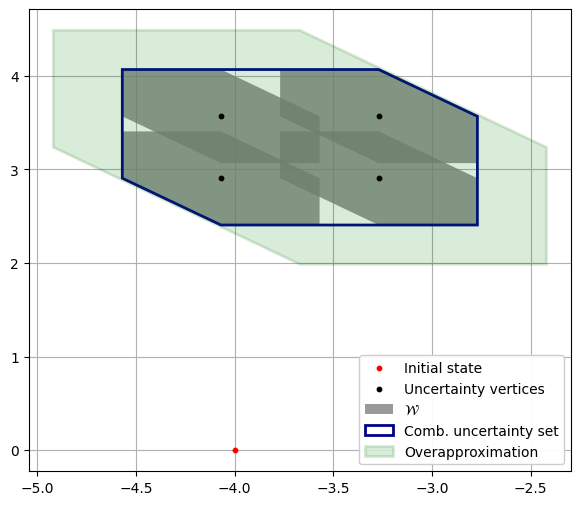

In [15]:
# additional imports from ampyc
from ampyc.utils import qhull, LQR

# compute the LQR controller for simulation of the uncertain dynamics
K, _ = LQR(sys.A, sys.B, params.ctrl.Q, params.ctrl.R)

# define initial state
x_0 = np.array([[-4], [-0]])
n_D = len(sys.Delta_A) * len(sys.Delta_B)
x = np.zeros((n_D, sys.n))

# simulate the uncertain dynamics for one time step
i = 0
for dA in sys.Delta_A:
    for dB in sys.Delta_B:
        x_d = ((sys.A + dA) + (sys.B + dB) @ K) @ x_0 
        x[i, :] = x_d.flatten()
        i += 1

# add the disturbance set to the uncertain evolution
D = []
for p in x:
    D.append(p + sys.W)

# plotting
_, ax = plt.subplots(1, 1, figsize=(7, 6))

# plot the initial state and the uncertain evolution
plt.scatter(x_0[0], x_0[1], s=10, color='red', alpha=1.0, label='Initial state', zorder=3)
plt.scatter(x[:, 0], x[:, 1], s=10, color='black', alpha=1.0, label='Uncertainty vertices', zorder=3)

# plot the disturbance set around the uncertain evolution
for i, d in enumerate(D):
    if i == 0:
        d.plot(ax, fill=True, alpha=0.8, color='gray', zorder=2, label="$\mathcal{W}$")
    else:
        d.plot(ax, fill=True, alpha=0.8, color='gray', zorder=2)

# compute the combined uncertainty set and plot it
Omega = qhull(np.vstack([d.V for d in D]))
Omega.plot(fill=False, alpha=1, color='blue', edgecolor="darkblue", linewidth=2, label='Comb. uncertainty set', zorder=1)

# compute the center of the combined uncertainty set (only needed for visualization) and plot the overapproximation
center = x.sum(axis=0)/n_D
(center + 2.5*W_tilde).plot(fill=True, alpha=0.15, color='green', edgecolor="darkgreen", linewidth=2, label='Overapproximation', zorder=0)

plt.grid()
plt.legend(loc="lower right", framealpha=0.95)
plt.show()

Next, we compute the maximum RCI set again for the new disturbance set and plot it.

MRCI computation converged after 76 iterations.


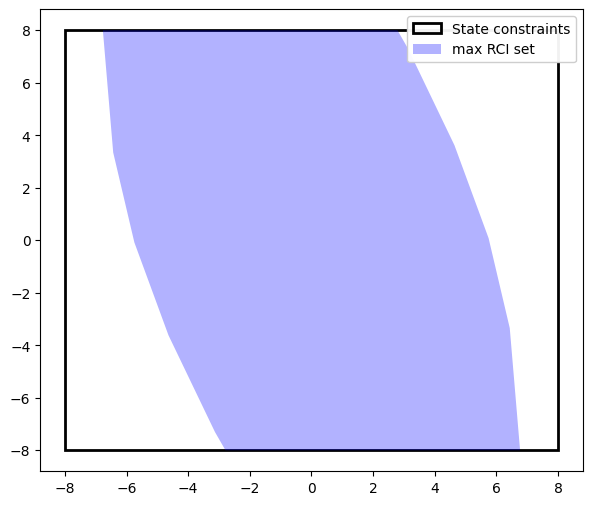

In [16]:
# compute the maximum RCI set for the new disturbance set
X_f = compute_mrci(sys, max_iter=100)

# plot the maximum RCI set in the state constraints
_, ax = plt.subplots(1, 1, figsize=(7, 6))
sys.X.plot(ax, fill=False, alpha=1, linewidth=2, color='black', label='State constraints')
X_f.plot(ax, fill=True, alpha=0.3, color='blue', label='max RCI set')
ax.set_xlim(sys.X.xlim)
ax.set_ylim(sys.X.ylim)

plt.legend(loc='upper right', framealpha=0.95)
plt.show()

Now we can compare the RoA of filter-based SLTMPC and SLS-MPC for the new disturbance set. This time, we use the new disturbance set as $\tilde{\mathcal{W}}$ and therefore have to structure the diagonal of the filter $\Sigma$ as diagonal matrices (see Remark 2 in [1]). For both methods, we use the maximum RCI set as the terminal set $\mathcal{X}_f$.

In [17]:
# re-initialize the filter-based SLTMPC and SLS-MPC with the new disturbance set
chen = SLS_MPC(sys, params.ctrl, solver='MOSEK', X_f=X_f, P_f=params.ctrl.Q)
slt = Filter_SLTMPC(sys, params.ctrl, solver='MOSEK', X_f=X_f, P_f=params.ctrl.Q, K_f=np.zeros((1,)),
                    W_tilde=W_tilde, structure="scalar", scale_terminal_set=False)

Computing RoA for filter-based SLTMPC...


100%|██████████| 20/20 [01:31<00:00,  4.55s/it]


Computing RoA for SLS-MPC...


100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


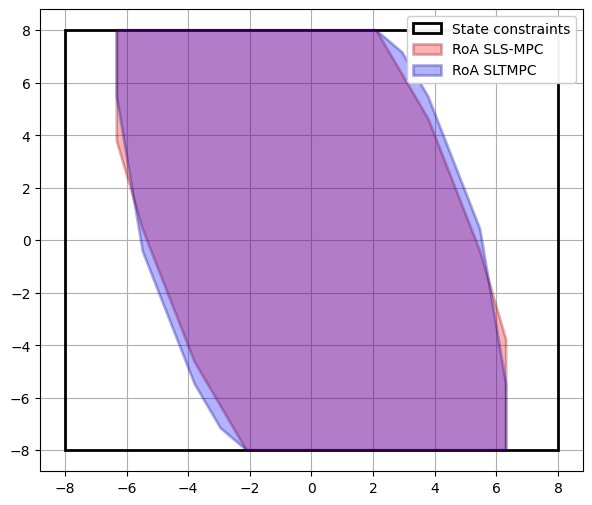

In [18]:
# compute the RoAs for both methods
print("Computing RoA for filter-based SLTMPC...")
RoA = compute_RoA(slt, sys, grid_size=20, solver='MOSEK')
print("Computing RoA for SLS-MPC...")
RoA_chen = compute_RoA(chen, sys, grid_size=20, solver='MOSEK')

# plot the RoAs
_, ax = plt.subplots(1, 1, figsize=(7, 6))
sys.X.plot(ax=ax, fill=False, color="black", linewidth=2, alpha=1., label='State constraints')
RoA_chen.plot(ax=ax, color="red", edgecolor="darkred", linewidth=2, alpha=0.3, label='RoA SLS-MPC')
RoA.plot(ax=ax, color="blue", edgecolor="darkblue", linewidth=2, alpha=0.3, label='RoA SLTMPC')

ax.set_xlim(sys.X.xlim)
ax.set_ylim(sys.X.ylim)

plt.legend(loc="upper right", framealpha=0.95)
plt.grid()
plt.show()

In [19]:
print(f"Filter-based SLTMPC coverage: {compute_coverage(RoA, X_f, sys.X, grid_size=200):.2%}")
print(f"SLS-MPC coverage: {compute_coverage(RoA_chen, X_f, sys.X, grid_size=200):.2%}")

Filter-based SLTMPC coverage: 94.88%
SLS-MPC coverage: 92.65%


We observe that the RoA of filter-based SLTMPC is larger than the RoA of SLS-MPC, which is expected since filter-based SLTMPC with can better overapproximate the combined uncertainties using a carefully designed auxiliary disturbance set $\tilde{\mathcal{W}}$.

To further stress this point, we update $\tilde{\mathcal{W}}$ with an empirically determined correction polytope and investigate if we can further increase the RoA of filter-based SLTMPC.

In [20]:
W_tilde = W + Polytope(np.array([[1, 0], [-1, 0], [0, 1], [0, -1]]), np.array([0.4, 0.4, 0.2, 0.2]))

# re-initialize filter-based SLTMPC with the updated W_tilde
slt = Filter_SLTMPC(sys, params.ctrl, solver='MOSEK', X_f=X_f, P_f=params.ctrl.Q, K_f=np.zeros((1,)),
                    W_tilde=W_tilde, structure="scalar", scale_terminal_set=False)

Computing RoA for filter-based SLTMPC...


100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


Computing RoA for SLS-MPC...


100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


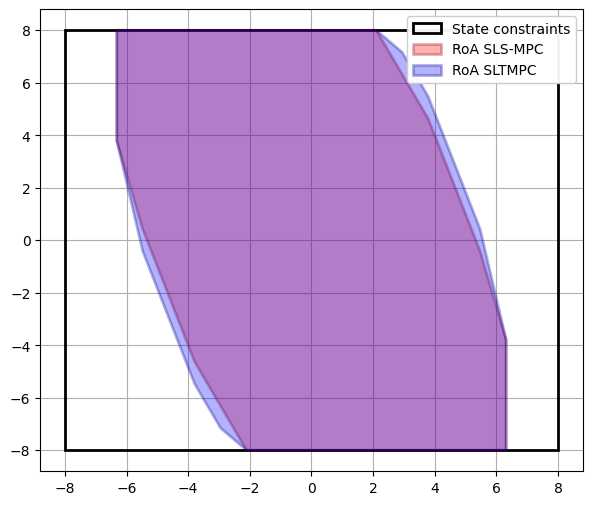

In [21]:
# compute the RoAs for both methods
print("Computing RoA for filter-based SLTMPC...")
RoA = compute_RoA(slt, sys, grid_size=20, solver='MOSEK')
print("Computing RoA for SLS-MPC...")
RoA_chen = compute_RoA(chen, sys, grid_size=20, solver='MOSEK')

# plot the RoAs
_, ax = plt.subplots(1, 1, figsize=(7, 6))
sys.X.plot(ax=ax, fill=False, color="black", linewidth=2, alpha=1., label='State constraints')
RoA_chen.plot(ax=ax, color="red", edgecolor="darkred", linewidth=2, alpha=0.3, label='RoA SLS-MPC')
RoA.plot(ax=ax, color="blue", edgecolor="darkblue", linewidth=2, alpha=0.3, label='RoA SLTMPC')

ax.set_xlim(sys.X.xlim)
ax.set_ylim(sys.X.ylim)

plt.legend(loc="upper right", framealpha=0.95)
plt.grid()
plt.show()

In [22]:
print(f"Filter-based SLTMPC coverage: {compute_coverage(RoA, X_f, sys.X, grid_size=200):.2%}")
print(f"SLS-MPC coverage: {compute_coverage(RoA_chen, X_f, sys.X, grid_size=200):.2%}")

Filter-based SLTMPC coverage: 95.78%
SLS-MPC coverage: 92.65%


We see that the RoA of filter-based SLTMPC is further increased, which shows that with a carefully designed auxiliary disturbance set $\tilde{\mathcal{W}}$, the conservativeness of filter-based SLTMPC can be significantly improved. This is a key advantage of filter-based SLTMPC over SLS-MPC, as it allows for more fine-tuning of the method to the specific uncertainties of the system.

### Recursively feasible filter-based SLTMPC

As noted in the paper, the main downsides of SLS-MPC [2] and filter-based SLTMPC (23) in [1] is that they are not recursively feasible and that they rely on a terminal set $\mathcal{X}_f$ computed for the combined model and additive uncertainties. The recursively feasible version of filter-based SLTMPC (32) in [1] addresses these issues by using a scaled terminal set, which is only required to be robust positively invariant (RPI) for the auxiliary disturbance set $\tilde{\mathcal{W}}$. This simplifies the terminal set design and ensures recursive feasibility.

Below, we demonstrate the advantages of this method by comparing it to SLS-MPC [2]. For this, we re-initialize the system from scratch but increase the size of the additive disturbance.

In [23]:
params = FilterSLTMPCParams(sys={"sig_w": 0.3})
sys = UncertainDoubleIntegrator(params.sys)

Successfully initialized experiment 'Filter-based SLTMPC'.


Then, we recompute the maximum RCI set (used in SLS-MPC) and the maximum RPI set (used in recursively feasible filter-based SLTMPC). Subsequently, we plot both sets to visualize the stark difference between the two sets.

In [24]:
# compute the RCI set
rci = compute_mrci(sys, max_iter=100)

# set the additive disturbance set as the auxiliary disturbance set for filter-based SLTMPC
W_tilde = sys.W

# compute the RPI set under the LQR terminal controller
K_f, P_f = LQR(sys.A, sys.B, params.ctrl.Q, params.ctrl.R)
Omega = Polytope(np.vstack([sys.X.A, sys.U.A @ K_f]), np.hstack([sys.X.b, sys.U.b]))
rpi = compute_mrpi(Omega, sys.A + sys.B @ K_f, W_tilde)

MRCI computation converged after 6 iterations.
MRPI computation converged after 1 iterations.


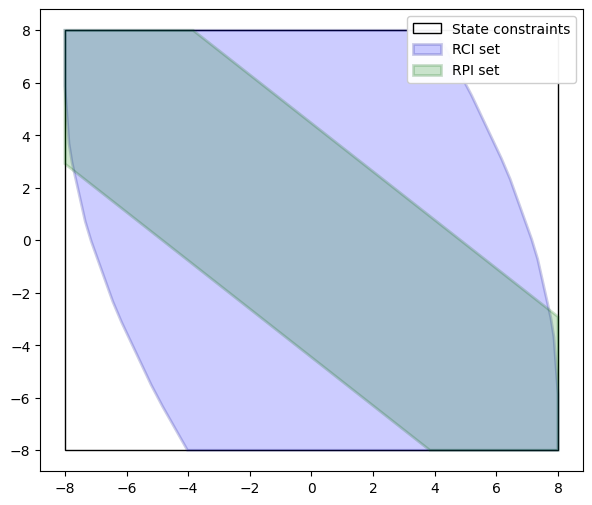

In [25]:
# plot the RCI and RPI sets
_, ax = plt.subplots(1, 1, figsize=(7, 6))
sys.X.plot(ax, fill=False, alpha=1, color='black', label='State constraints')
rci.plot(ax, fill=True, alpha=0.2, color='blue', edgecolor="darkblue", linewidth=2, label='RCI set')
rpi.plot(ax, fill=True, alpha=0.2, color='green', edgecolor="darkgreen", linewidth=2, label='RPI set')

ax.set_xlim(sys.X.xlim)
ax.set_ylim(sys.X.ylim)

plt.legend(loc='upper right', framealpha=0.95)
plt.show()

Next, we compare the RoAs of the two methods again. Note, that we use the RPI set and the LQR controller as the terminal set $\mathcal{X}_f$ and terminal controller in the recursively feasible filter-based SLTMPC method and that we structure the diagonal of the filter $\Sigma$ as diagonal matrices (see Remark 3 in [1]), since $\tilde{\mathcal{W}}$ is a hyperrectangle. For SLS-MPC, we use the maximum RCI set as the terminal set as before.

In [26]:
# initialize recursively feasible filter-based SLTMPC and SLS-MPC
slt = Filter_SLTMPC(sys, params.ctrl, solver='MOSEK', X_f=rpi, P_f=P_f, K_f=K_f,
                    W_tilde=W_tilde, structure="diagonal", scale_terminal_set=True)
chen = SLS_MPC(sys, params.ctrl, solver='MOSEK', X_f=rci, P_f=params.ctrl.Q)

Using scaled terminal set!


Computing RoA for filter-based SLTMPC...


100%|██████████| 20/20 [00:53<00:00,  2.69s/it]


Computing RoA for SLS-MPC...


100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


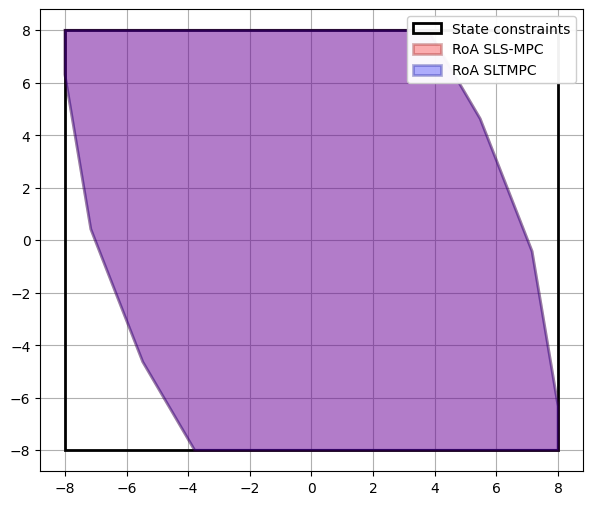

In [27]:
# compute the RoAs for both methods
print("Computing RoA for filter-based SLTMPC...")
RoA = compute_RoA(slt, sys, grid_size=20, solver='MOSEK')
print("Computing RoA for SLS-MPC...")
RoA_chen = compute_RoA(chen, sys, grid_size=20, solver='MOSEK')

# plot the RoAs
_, ax = plt.subplots(1, 1, figsize=(7, 6))
sys.X.plot(ax=ax, fill=False, color="black", linewidth=2, alpha=1., label='State constraints')
RoA_chen.plot(ax=ax, color="red", edgecolor="darkred", linewidth=2, alpha=0.3, label='RoA SLS-MPC')
RoA.plot(ax=ax, color="blue", edgecolor="darkblue", linewidth=2, alpha=0.3, label='RoA SLTMPC')

ax.set_xlim(sys.X.xlim)
ax.set_ylim(sys.X.ylim)

plt.legend(loc="upper right", framealpha=0.95)
plt.grid()
plt.show()

In [28]:
print(f"Filter-based SLTMPC coverage: {compute_coverage(RoA, rci, sys.X, grid_size=200):.2%}")
print(f"SLS-MPC coverage: {compute_coverage(RoA_chen, rci, sys.X, grid_size=200):.2%}")

Filter-based SLTMPC coverage: 97.70%
SLS-MPC coverage: 97.70%


We note that the two RoAs are identical with very high coverage of the maximum RCI set. To confirm this, we also directly check equivalence.

In [29]:
RoA == RoA_chen

True

Even though the two RoAs above are identical, SLS-MPC is generally less conservative than the recursively feasible filter-based SLTMPC method. This is due to the additional constraints needed for recursive feasibility. To show this, we compute the RoA coverage of the maximum RCI set for both methods again, but this time vary the size of the uncertainty in dynamics matrix $A$.

**Remark:** Running the next cell will take a while (~10 minutes). Still, the results will be different from the paper (i.e. Figure 2 in [1]). To obtain the same results as in the paper, the grid to compute the RoA would need to be much finer, e.g. `grid_size=50` or even higher. However, this will also significantly increase the computation time.

In [30]:
# define a range of eps_A values for which the RoAs are computed
EPS_A = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

cov_slt = []
cov_chen = []

for i, eps_A in enumerate(EPS_A):
    print(f"computing RoA for eps_A = {eps_A:.1f}\n")
    print(f"intermediate output:")

    # re-initialize the system with the current eps_A
    params = FilterSLTMPCParams(sys={"eps_A": eps_A})
    sys = UncertainDoubleIntegrator(params.sys)

    # compute RCI set
    rci = compute_mrci(sys, max_iter=100)

    # set the additive disturbance set as the auxiliary disturbance set for filter-based SLTMPC
    W_tilde = sys.W

    # compute RPI set
    K_f, P_f = LQR(sys.A, sys.B, params.ctrl.Q, params.ctrl.R)
    Omega = Polytope(np.vstack([sys.X.A, sys.U.A @ K_f]), np.hstack([sys.X.b, sys.U.b]))
    rpi = compute_mrpi(Omega, sys.A + sys.B @ K_f, W_tilde)

    # re-initialize recursively feasible filter-based SLTMPC and SLS-MPC
    slt = Filter_SLTMPC(sys, params.ctrl, solver='MOSEK', X_f=rpi, P_f=P_f, K_f=K_f,
                        W_tilde=W_tilde, structure="diagonal", scale_terminal_set=True)
    chen = SLS_MPC(sys, params.ctrl, solver='MOSEK', X_f=rci, P_f=params.ctrl.Q)

    # compute the RoAs for both methods
    RoA = compute_RoA(slt, sys, grid_size=20, solver='MOSEK')
    RoA_chen = compute_RoA(chen, sys, grid_size=20, solver='MOSEK')

    # compute and store the coverage of the RoAs with respect to the maximum RCI set
    cov_slt.append(compute_coverage(RoA, rci, sys.X))
    cov_chen.append(compute_coverage(RoA_chen, rci, sys.X))

    print(f"\nDone with eps_A {i+1} of {len(EPS_A)}")
    print(f"Coverage SLTMPC: {cov_slt[-1]:.2%}\nCoverage SLS-MPC: {cov_chen[-1]:.2%}\n")


computing RoA for eps_A = 0.0

intermediate output:
Successfully initialized experiment 'Filter-based SLTMPC'.
MRCI computation converged after 3 iterations.
MRPI computation converged after 1 iterations.
Using scaled terminal set!


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]



Done with eps_A 1 of 6
Coverage SLTMPC: 99.23%
Coverage SLS-MPC: 99.23%

computing RoA for eps_A = 0.1

intermediate output:
Successfully initialized experiment 'Filter-based SLTMPC'.
MRCI computation converged after 5 iterations.
MRPI computation converged after 1 iterations.
Using scaled terminal set!


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]



Done with eps_A 2 of 6
Coverage SLTMPC: 98.76%
Coverage SLS-MPC: 98.76%

computing RoA for eps_A = 0.2

intermediate output:
Successfully initialized experiment 'Filter-based SLTMPC'.
MRCI computation converged after 45 iterations.
MRPI computation converged after 1 iterations.
Using scaled terminal set!


100%|██████████| 20/20 [00:41<00:00,  2.06s/it]



Done with eps_A 3 of 6
Coverage SLTMPC: 88.69%
Coverage SLS-MPC: 96.52%

computing RoA for eps_A = 0.3

intermediate output:
Successfully initialized experiment 'Filter-based SLTMPC'.
MRCI computation converged after 38 iterations.
MRPI computation converged after 1 iterations.
Using scaled terminal set!


100%|██████████| 20/20 [00:39<00:00,  1.95s/it]



Done with eps_A 4 of 6
Coverage SLTMPC: 88.00%
Coverage SLS-MPC: 88.00%

computing RoA for eps_A = 0.4

intermediate output:
Successfully initialized experiment 'Filter-based SLTMPC'.
MRCI computation converged after 29 iterations.
MRPI computation converged after 1 iterations.
Using scaled terminal set!


100%|██████████| 20/20 [00:32<00:00,  1.63s/it]



Done with eps_A 5 of 6
Coverage SLTMPC: 82.59%
Coverage SLS-MPC: 82.59%

computing RoA for eps_A = 0.5

intermediate output:
Successfully initialized experiment 'Filter-based SLTMPC'.
MRCI computation converged after 75 iterations.
MRPI computation converged after 1 iterations.
Using scaled terminal set!


100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


Done with eps_A 6 of 6
Coverage SLTMPC: 73.34%
Coverage SLS-MPC: 77.61%



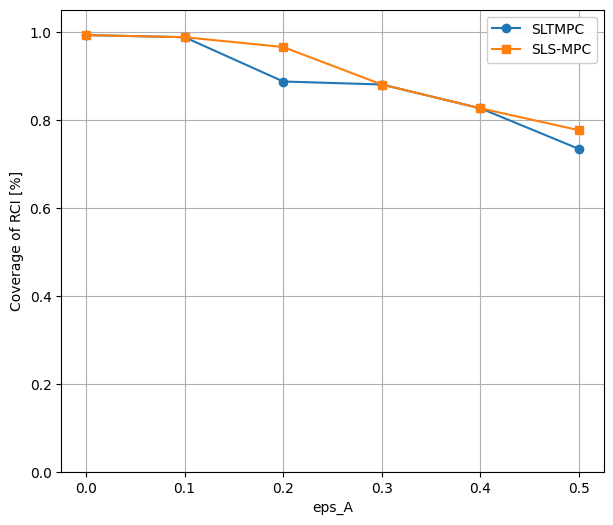

In [31]:
# plot the coverages for both methods
_, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(EPS_A, cov_slt, label='SLTMPC', marker='o')
ax.plot(EPS_A, cov_chen, label='SLS-MPC', marker='s')

ax.set_xlabel('eps_A')
ax.set_ylabel('Coverage of RCI [%]')
ax.set_ylim(0, 1.05)

plt.legend(loc="upper right", framealpha=0.95)
plt.grid()
plt.show()

While recursively feasible filter-based SLTMPC is more conservative than SLS-MPC, the coverage is still very high and the difference in coverage is deminished as the horizon $N$ increases (see Section 6.1 in [1]).

The advantages of the recursively feasible version are the simplified terminal set design and the recursive feasibility guarantee.

1. The former is particularly important for systems with larger dimensions (i.e. going beyond the double integrator system used in this notebook), where the design of a RCI or RPI set for the combined model and additive uncertainties becomes increasingly complex, while computing a RPI set only for the auxiliary disturbance set $\tilde{\mathcal{W}}$ is much simpler. Especially, since $\tilde{\mathcal{W}}$ can be designed with this in mind. In the paper [1], this is show-cased for a 6-dimensional model rocket system.
1. The latter is crucial for applying the MPC method in a receding horizon fashion, which is shown below. Since SLS-MPC [2] is not recursively feasible for a receding horizon, it needs to be implemented as a shrinking horizon controller with a backup controller defined through the RCI set. This increases the implementation complexity and results in a less performant controller in closed-loop operation.

Below, we apply recursively feasible filter-based SLTMPC and SLS-MPC in closed-loop. For this we re-initialize the system and import the backup controller for SLS-MPC.

**Remarks:**
1. Note that we add some regularization to recursively feasible filter-based SLTMPC to ensure that the closed-loop trajectories converge closer to the origin (see Remark 4 in [1]).
1. The closed-loop trajectories are not identical to the ones shown in the paper, since the number of trajectories is much smaller and the model uncertainties are randomly sampled here. To obtain the same results as in the paper, the number of trajectories would need to be increased and the model uncertainties would need to be fixed. However, this would also significantly increase the computation time.

In [32]:
# import backup controller
from sltmpc.controllers import RCI_Controller

# re-initialize the system
params = FilterSLTMPCParams(sys={"sig_w": 0.3})
sys = UncertainDoubleIntegrator(params.sys)

# compute RCI set
rci = compute_mrci(sys, max_iter=100)

# set the additive disturbance set as the auxiliary disturbance set for filter-based SLTMPC
W_tilde = sys.W

# compute RPI set
K_f, P_f = LQR(sys.A, sys.B, params.ctrl.Q, params.ctrl.R)
Omega = Polytope(np.vstack([sys.X.A, sys.U.A @ K_f]), np.hstack([sys.X.b, sys.U.b]))
rpi = compute_mrpi(Omega, sys.A + sys.B @ K_f, W_tilde)

# initialize the backup controller for SLS-MPC
rci_controller = RCI_Controller(sys, params.ctrl, solver="MOSEK", X_f=rci)
# initialize recursively feasible filter-based SLTMPC including regularization
slt = Filter_SLTMPC(sys, params.ctrl, solver='MOSEK', X_f=rpi, P_f=P_f, K_f=K_f,
                    W_tilde=W_tilde, structure="diagonal", scale_terminal_set=True,
                    regularize=lambda x: 0.4*cp.sum_squares(cp.vec(x[4], order='F')) + cp.sum_squares(cp.vec(x[5], order='F')))

# get the simulation parameters
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj

# get the initial state from the parameters
x_0 = params.sim.x_0

# set the random seed for reproducibility
sys.noise_generator.seed(42)
sys.dA_gen.reset(sys.Delta_A, seed=0)
sys.dB_gen.reset(sys.Delta_B, seed=42)

# allocate state and input trajectories
x_slt = np.zeros((num_steps+1, sys.n, num_traj))
x_chen = np.zeros((num_steps+1, sys.n, num_traj))
u_slt = np.zeros((num_steps, num_traj))
u_chen = np.zeros((num_steps, num_traj))
x_slt[0,:,:] = x_0
x_chen[0,:,:] = x_0

# get the horizon for the shrinking horizon strategy
ctrl_params = params.ctrl
NN = ctrl_params.N

# simulate the closed-loop
for i in range(num_traj):
    N = NN # reset N for each trajectory
    for j in range(num_steps):
        ### rec. feas. filter-based SLTMPC (receding horizon strategy)

        # solve the MPC problem
        v, z, out, error_msg = slt.solve(x_slt[j,:,i], additional_parameters={}, verbose=False)

        # check if the solver returned an error message
        if error_msg != None:
            raise Exception(error_msg)

        # advance the system
        u_slt[j,i] = v[0].item() # need .item(), since u is a scalar
        x_slt[j+1,:,i] = sys.get_state(x_slt[j,:,i], u_slt[j,i]).reshape(-1)
        ###

        ### SLS-MPC (shrinking horizon strategy)
        if N > 1: # if the horizon is larger than 1, use SLS-MPC with a shrinking horizon

            # initialize the SLS-MPC controller with the current horizon
            ctrl_params.N = N
            chen = SLS_MPC(sys, ctrl_params, solver='MOSEK', X_f=rci, P_f=ctrl_params.Q)

            # solve the MPC problem
            v, z, out, error_msg = chen.solve(x_chen[j,:,i], additional_parameters={}, verbose=False)

            # check if the solver returned an error message
            if error_msg != None:
                raise Exception(error_msg)
        
            # advance the system
            u_chen[j,i] = v[0].item() # need .item(), since u is a scalar
            x_chen[j+1,:,i] = sys.get_state(x_chen[j,:,i], u_chen[j,i]).reshape(-1)

            # decrease the horizon for the next iteration
            N -= 1
        
        else: # if the horizon is 1, use the backup controller
            # solve the backup controller problem
            v, z, error_msg = rci_controller.solve(x_chen[j,:,i], additional_parameters={}, verbose=False)

            # check if the solver returned an error message
            if error_msg != None:
                raise Exception(error_msg)
        
            # advance the system
            u_chen[j,i] = v.item() # need .item(), since u is a scalar
            x_chen[j+1,:,i] = sys.get_state(x_chen[j,:,i], u_chen[j,i]).reshape(-1)
        ###

Successfully initialized experiment 'Filter-based SLTMPC'.
MRCI computation converged after 6 iterations.
MRPI computation converged after 1 iterations.
Using scaled terminal set!


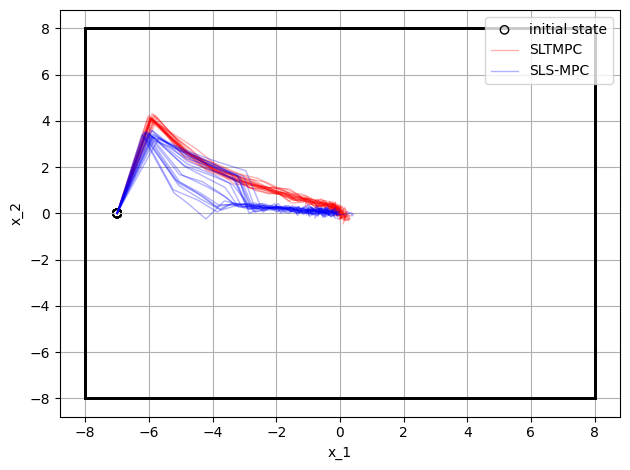

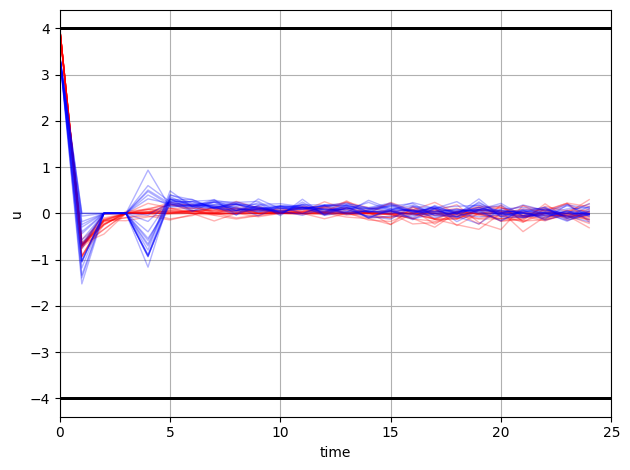

In [33]:
from ampyc.plotting import plot_x_state_state, plot_u

# plot the closed-loop state and input trajectories
# rec. feas. filter-based SLTMPC
params.plot.color = "red"
params.plot.alpha = 0.3
plot_x_state_state(1, x_slt, sys.X, params.plot, label='SLTMPC')
plot_u(2, u_slt, sys.U, params.plot)

# SLS-MPC
params.plot.color = "blue"
params.plot.alpha = 0.3
plot_x_state_state(1, x_chen, sys.X, params.plot, label='SLS-MPC')
plot_u(2, u_chen, sys.U, params.plot)

We note that the SLS-MPC closed-loop trajectories exhibit more erratic behavior due to the switching shrinking horizon strategy. This can be also confirmed by computing the closed-loop costs.

In [34]:
# additional imports
from scipy.linalg import block_diag, sqrtm
from numpy.linalg import norm

# rearrange the state trajectories for cost computation
xx_slt = x_slt.transpose((0,2,1))
xx_chen = x_chen.transpose((0,2,1))

# allocate cost arrays
cost_slt = np.zeros(num_traj)
cost_chen = np.zeros(num_traj)

# compute the cost matrices
C = [sqrtm(params.ctrl.Q)] * num_steps + [params.ctrl.R] * num_steps

for i in range(num_traj):
    ### rec. feas. filter-based SLTMPC
    x = xx_slt[:,i][:-1]
    u = u_slt[:,i]

    # compute the closed-loop cost
    cost_slt[i] = norm(block_diag(*C) @ np.vstack([x.reshape(-1,1), u.reshape(-1,1)]), ord=2)**2
    ###

    ### SLS-MPC
    x = xx_chen[:,i][:-1]
    u = u_chen[:,i]

    # compute the closed-loop cost
    cost_chen[i] = norm(block_diag(*C) @ np.vstack([x.reshape(-1,1), u.reshape(-1,1)]), ord=2)**2
    ###

print("Method \t\tMean cost [-] \tImprovement [%]")
print("---------------------------------------------")
print(f"SLTMPC: \t{np.mean(cost_slt):.2f} \t{(np.mean(cost_chen) - np.mean(cost_slt))/np.mean(cost_chen)*100:.2f}")
print(f"SLS-MPC: \t{np.mean(cost_chen):.2f}")

Method 		Mean cost [-] 	Improvement [%]
---------------------------------------------
SLTMPC: 	1934.67 	3.88
SLS-MPC: 	2012.85
